In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

%matplotlib inline

В переменной `path` записан путь до директории с файлами `twitter_rv.net` и `numeric2screen.txt`.

In [2]:
sqlContext = SQLContext(sc)
path = 'C:/workspace/twitter_rv'

Загрузим данные

In [3]:
t_graph = sqlContext.read.csv(f'{path}/twitter_rv.net', sep='\t', schema=StructType([
    StructField('user_id', IntegerType(), nullable=True),
    StructField('follower_id', IntegerType(), nullable=True)
]))
t_graph.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- follower_id: integer (nullable = true)



In [4]:
numeric2screen = sqlContext.read.csv(f'{path}/numeric2screen.txt', sep=' ', schema=StructType([
    StructField('user_id', IntegerType(), nullable=True),
    StructField('screen_name', StringType(), nullable=True)
]))
numeric2screen.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- screen_name: string (nullable = true)



Сначала попробуем решить задачу для маленького датасета. Для этого воспользуемся функцией `sample`, которая позволяет взять часть данных, затем получим Pandas датафрейм с помощью функции `toPandas` и сохраним эти данные в csv-файл, а затем загрузим данные снова в переменную `t_graph_trimmed`, дальше будем пользоваться датафреймом из этой переменной.

In [5]:
t_graph_sampled = t_graph.sample(withReplacement=False, fraction=0.0005, seed=42)

In [6]:
pd_t_graph = t_graph_sampled.toPandas()
pd_t_graph.to_csv(f'{path}/twitter_rv.trimmed.net', sep='\t', header=False, index=False)

In [7]:
t_graph_trimmed = sqlContext.read.csv(f'{path}/twitter_rv.trimmed.net', sep='\t', schema=StructType([
    StructField('user_id', IntegerType(), nullable=True),
    StructField('follower_id', IntegerType(), nullable=True)
]))
t_graph_trimmed.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- follower_id: integer (nullable = true)



#### 1. Оцените распределение количества подписчиков (фолловеров). Для этого подсчитайте количества пользователей в следующих интервалах по количеству подписчиков: [1,10], [11,100], [101,1000], [1001,10000], [10001,100000] и т. д.

Попробуем решить эту задачу. Сначала посчитаем количества пользователей в интервалах для Pandas датафрейма

Count from 1 to 9: 455482
Count from 10 to 99: 2734
Count from 100 to 999: 308
Count from 1000 to 9999: 5
Count from 10000 to 99999: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F395D81668>]], dtype=object)

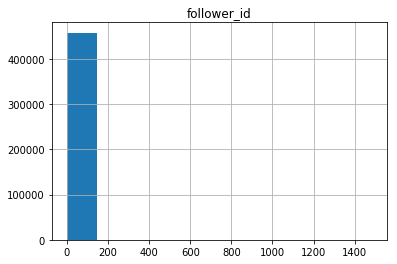

In [8]:
c = pd_t_graph.groupby('user_id').count()
r = np.logspace(0, 5, num=6, base=10, dtype=np.int)
counts = [0]*(len(r) - 1)
for i in range(len(r) - 1):
    from_ = r[i]
    to_ = r[i + 1] - 1
    count_ = len(c[(c.follower_id >= from_) & (c.follower_id <= to_)])
    counts[i] = count_
    print(f'Count from {from_} to {to_}: {count_}')
c.hist()

Видно, что большинство пользователей в нашей сокращенной выборке имеют от 1 до 9 подписчиков.

Теперь попробуем посчитать то же самое для нашего spark-датафрейма:

In [9]:
c = t_graph_trimmed.groupby('user_id').count()
for i in range(len(r) - 1):
    from_ = r[i]
    to_ = r[i + 1] - 1
    count_ = c.filter(f'count >= {from_} and count <= {to_}').count()
    counts[i] = count_
    print(f'Count from {from_} to {to_}: {count_}')

Count from 1 to 9: 455482
Count from 10 to 99: 2734
Count from 100 to 999: 308
Count from 1000 to 9999: 5
Count from 10000 to 99999: 0


Очевидно, что несколько раз пересчитывать количество пользователей по количеству подписчиков для каждого интервала неправильно - это займет очень продолжительное время на всех данных.

DataFrame API, кажется, не позволяет посчитать количество в интервалах одновременно, поэтому нужно воспользоваться SQL интерфейсом:

In [10]:
def show_distribution(t_graph, ranges):
    t_graph.createOrReplaceTempView('twitter')
    count = len(ranges) - 1
    count_strs = [None]*count
    for i in range(count):
        from_ = ranges[i]
        to_ = ranges[i + 1] - 1
        s = f'count(CASE WHEN followers_count >= {from_} AND followers_count <= {to_} THEN 1 END) AS {from_}_to_{to_}'
        count_strs[i] = s

    sqlContext.sql(f'''
        SELECT {','.join(count_strs)}
        FROM (
            SELECT user_id, count(user_id) as followers_count FROM twitter
            GROUP BY user_id
        ) AS group
    ''').show(5)

show_distribution(t_graph_trimmed, np.logspace(0, 5, num=6, base=10, dtype=np.int))

+------+--------+----------+------------+--------------+
|1_to_9|10_to_99|100_to_999|1000_to_9999|10000_to_99999|
+------+--------+----------+------------+--------------+
|455482|    2734|       308|           5|             0|
+------+--------+----------+------------+--------------+



Это работает быстрее чем предыдущий вариант.

#### 2. Определите Top50 пользователей по количеству подписчиков. Замените идентификаторы пользователей на их имена.

Это можно сделать с помощью следующего запроса на DataFrame API:

In [6]:
(t_graph_trimmed
     .groupby('user_id').count()
     .sort('count', ascending=False)
     .join(numeric2screen, 'user_id')
     .drop('user_id').show(50))

NameError: name 't_graph_trimmed' is not defined

#### 3. Вычислите среднее количество подписчиков у пользователя.



In [12]:
pd_t_graph.groupby('user_id').count().mean()

follower_id    1.601576
dtype: float64

In [13]:
t_graph_trimmed.groupby('user_id').count().agg({'count': 'avg'}).show()

+------------------+
|        avg(count)|
+------------------+
|1.6015759090482826|
+------------------+



---

Теперь осталось лишь запустить код, написанный выше, на всех данных.

#### 1. Оцените распределение количества подписчиков (фолловеров).

In [14]:
show_distribution(t_graph, np.logspace(0, 8, num=9, base=10, dtype=np.int))

+--------+--------+----------+------------+--------------+----------------+------------------+--------------------+
|  1_to_9|10_to_99|100_to_999|1000_to_9999|10000_to_99999|100000_to_999999|1000000_to_9999999|10000000_to_99999999|
+--------+--------+----------+------------+--------------+----------------+------------------+--------------------+
|24406938|14364021|   1186152|      139535|          6205|             359|                71|                   0|
+--------+--------+----------+------------+--------------+----------------+------------------+--------------------+



Видно, что больше всего людей имеют от 1 до 9 подписчиков (~24 миллиона), также довольно много от 10 до 99 подписчиков (~14 миллионов).

#### 2. Определите Top50 пользователей по количеству подписчиков. Замените идентификаторы пользователей на их имена.

In [7]:
(t_graph
     .groupby('user_id').count()
     .sort('count', ascending=False)
     .join(numeric2screen, 'user_id', 'left')
     .show(50))

+--------+-------+-----------+
| user_id|  count|screen_name|
+--------+-------+-----------+
|19058681|2997469|       null|
|15846407|2679639|       null|
|16409683|2674874|       null|
|  428333|2450749|       null|
|19397785|1994926|       null|
|  783214|1959708|       null|
|16190898|1885782|       null|
|  813286|1882889|       null|
|19757371|1844499|       null|
|17461978|1843561|       null|
|25365536|1790771|       null|
|19554706|1691919|       null|
|15485441|1668193|       null|
|18220175|1657119|       null|
|16727535|1651207|       null|
|  807095|1524048|       null|
|18863815|1517067|       null|
|27104736|1477423|       null|
|14075928|1380160|       null|
|17220934|1377332|       null|
|18091904|1318909|       null|
|18222378|1318378|       null|
|20536157|1278103|       null|
|21879024|1277163|       null|
|19329393|1269341|       null|
|16827333|1241331|       null|
|      20|1213787|       null|
|  972651|1210996|       null|
|26885308|1200472|       null|
| 627355

Можно обратить внимание, что топ 10 не изменился в сравнении с той частью данных, на которой код запускался ранее.

#### 3. Вычислите среднее количество подписчиков у пользователя.

In [16]:
t_graph.groupby('user_id').count().agg({'count': 'avg'}).show()

+------------------+
|        avg(count)|
+------------------+
|36.614589763864956|
+------------------+



Среднее количество подписчиков у человека выросло с 1.6 до 36.6.